In [23]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ======================================================
#  DATASET CONFIGURATION
#  (Fill in the correct feature names for each dataset)
# ======================================================

DATASETS = {
    "adult": {
        "csv_path": "adult_preprocessed.csv",
        "feature_cols": [
            'age','final-weight','education-num','marital-status','occupation',
            'relationship','capital-gain','hours-per-week','native-country','income'
        ],
        "sensitive_col": "sex",
        "k": 7
    },

    "credit": {
        "csv_path": "credit_preprocessed.csv",     # <-- FILL THIS
        "feature_cols": [
            'LIMIT_BAL', 'SEX', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
            'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
            'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'MARRIAGE'
        ],
        "sensitive_col": "MARRIAGE",                    # <-- Example, change if needed
        "k": 5
    },

    "student": {
        "csv_path": "student_preprocessed.csv",         # <-- FILL THIS
        "feature_cols": [
            'school', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
           'Mjob', 'Fjob', 'traveltime', 'studytime', 'failures', 'schoolsup',
           'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet',
           'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
           'absences', 'sex'
        ],
        "sensitive_col": "sex",                    # <-- Example
        "k": 5
    },

    "bank": {
        "csv_path": "bank_preprocessed.csv",
        "feature_cols": [
            'age', 'balance', 'duration','marital'
        ],
        "sensitive_col": "marital",         # <-- Example
        "k": 5
    }
}


In [13]:
def compute_pairwise_fairness(X, XA, XB, centroids, eps=1e-12):
    """
    Compute mu_A, mu_B, and min(mu_A, mu_B) using squared distance
    to the hyperplane between the two closest centroids.
    """

    def sq_dist_to_hyperplane(x, m1, m2):
        m = 0.5 * (m1 + m2)
        v = m2 - m1
        norm_v = np.maximum(np.linalg.norm(v), eps)
        v = v / norm_v
        return ((x - m) @ v) ** 2

    fairness_A = []
    fairness_B = []

    # Group A
    for x in XA:
        d = np.linalg.norm(centroids - x, axis=1)
        m1_idx = np.argmin(d)
        m1 = centroids[m1_idx]
        d[m1_idx] = np.inf
        m2 = centroids[np.argmin(d)]
        fairness_A.append(sq_dist_to_hyperplane(x, m1, m2))

    # Group B
    for x in XB:
        d = np.linalg.norm(centroids - x, axis=1)
        m1_idx = np.argmin(d)
        m1 = centroids[m1_idx]
        d[m1_idx] = np.inf
        m2 = centroids[np.argmin(d)]
        fairness_B.append(sq_dist_to_hyperplane(x, m1, m2))

    mu_A = float(np.mean(fairness_A)) if len(fairness_A) > 0 else 0.0
    mu_B = float(np.mean(fairness_B)) if len(fairness_B) > 0 else 0.0

    return mu_A, mu_B, min(mu_A, mu_B)


def compute_kmeans_loss(X, centroids, assignments):
    """
    Standard k-means within-cluster loss.
    """
    loss = 0.0
    for j, c in enumerate(centroids):
        pts = X[assignments == j]
        if len(pts) > 0:
            loss += np.sum((pts - c) ** 2)
    return loss


In [41]:
def run_separation_fair_kmeans_for_dataset(
    df: pd.DataFrame,
    feature_cols,
    sensitive_col: str,
    k: int,
    dataset_name: str,
    lambda2_list = (0.0, 0.2, 0.4, 0.6, 0.8, 1.0),
    num_seeds: int = 10,
    learning_rate: float = 0.01,
    num_iters: int = 500,
    eps: float = 1e-12
):
    """
    Runs the Separation Fair k-means training loop for one dataset.
    Returns per-lambda dictionaries with metrics and saves centers/assignments/d2_hp files.
    """

    # --- Prepare data ---
    X = df[feature_cols].values
    s = df[sensitive_col].values

    scaler = StandardScaler()
    X_input = scaler.fit_transform(X)

    XA = X_input[s > 0]
    XB = X_input[s <= 0]

    A_mask = (s > 0)
    B_mask = ~A_mask

    # Metric containers
    min_fair_dict_v4 = {l: [] for l in lambda2_list}
    fairness_gaps_v4 = {l: [] for l in lambda2_list}
    kmeans_costs_v4 = {l: [] for l in lambda2_list}
    max_fair_dict_lambda2  = {lam: [] for lam in lambda2_list}

    # Build S_vec once (vectorized membership: rows in XA → 0 else 1)
    X_input_c = np.ascontiguousarray(X_input)
    XA_c      = np.ascontiguousarray(XA)

    Xv  = X_input_c.view([('', X_input_c.dtype)] * X_input_c.shape[1]).ravel()
    XAv = XA_c.view([('', XA_c.dtype)] * XA_c.shape[1]).ravel()

    in_A = np.in1d(Xv, XAv)           # Boolean mask
    S_vec_global = np.where(in_A, 0, 1).astype(np.int32)

    # Output dirs (per dataset)
    root = Path("clustering_file_with_seed") / dataset_name
    unfair_dir = (root / "unfair_csv"); unfair_dir.mkdir(parents=True, exist_ok=True)
    fair_dir   = (root / "fair_csv");   fair_dir.mkdir(parents=True, exist_ok=True)

    d2hp_root = Path("d2hp_dumps") / dataset_name
    d2hp_root.mkdir(parents=True, exist_ok=True)

    N = len(X_input)

    # Main loops over λ and seeds
    for lam2 in lambda2_list:
        print(f"\n=== [{dataset_name}] λ = {lam2} ===")
        for seed in range(num_seeds):
            print(f"  --- seed = {seed} ---")
            np.random.seed(seed)
            initial_centroids = X_input[np.random.choice(N, k, replace=False)]
            centroids = initial_centroids.copy()

            for t in range(num_iters):
                # Assignments (k-means step)
                dists = np.sum((X_input[:, None, :] - centroids[None, :, :])**2, axis=2)
                assignments = np.argmin(dists, axis=1)

                # Fairness values (choose active branch = min)
                mu_A, mu_B, min_fair = compute_pairwise_fairness(X_input, XA, XB, centroids)

                # KMeans gradient (vectorized)
                grad_kmeans = np.zeros_like(centroids)
                sums = np.zeros_like(centroids)
                np.add.at(sums, assignments, X_input)
                counts = np.bincount(assignments, minlength=k).astype(np.float64).reshape(-1, 1)
                means = np.divide(sums, np.maximum(counts, 1.0), where=counts>0)
                grad_kmeans = 2.0 * counts * (centroids - means)

                # Fairness gradient (vectorized over group)
                grad_fair = np.zeros_like(centroids)
                group = XA if mu_A <= mu_B else XB
                if len(group) > 0:
                    dG = np.sum((group[:, None, :] - centroids[None, :, :])**2, axis=2)
                    m1_idx = np.argmin(dG, axis=1)
                    dG_mask = dG.copy()
                    dG_mask[np.arange(len(group)), m1_idx] = np.inf
                    m2_idx = np.argmin(dG_mask, axis=1)

                    m1 = centroids[m1_idx]
                    m2 = centroids[m2_idx]
                    m  = 0.5 * (m1 + m2)
                    v  = m2 - m1
                    vn = np.linalg.norm(v, axis=1, keepdims=True)
                    vhat = v / np.maximum(vn, eps)

                    s_vals = np.sum((group - m) * vhat, axis=1)
                    Px = (group - m) - vhat * s_vals[:, None]

                    grad_m1 = (2.0 * s_vals)[:, None] * (-(Px / np.maximum(vn, eps)) - 0.5 * vhat)
                    grad_m2 = (2.0 * s_vals)[:, None] * ( +(Px / np.maximum(vn, eps)) - 0.5 * vhat)

                    np.add.at(grad_fair, m1_idx, grad_m1)
                    np.add.at(grad_fair, m2_idx, grad_m2)

                    grad_fair /= len(group)

                # Final update
                centroids -= learning_rate * (grad_kmeans / N - lam2 * grad_fair)

            # After training
            dists = np.sum((X_input[:, None, :] - centroids[None, :, :])**2, axis=2)
            assignments = np.argmin(dists, axis=1)

            final_loss_v4 = compute_kmeans_loss(X_input, centroids, assignments) / N
            mu_A_v4, mu_B_v4, min_fair_v4 = compute_pairwise_fairness(X_input, XA, XB, centroids)
            diff_abs_v4 = abs(mu_A_v4 - mu_B_v4)
            valA = ((X_input[A_mask] - centroids[assignments[A_mask]])**2).sum() / A_mask.sum()
            valB = ((X_input[B_mask] - centroids[assignments[B_mask]])**2).sum() / B_mask.sum()
            max_fair = max(valA, valB)

            # Store metrics
            min_fair_dict_v4[lam2].append(min_fair_v4)
            fairness_gaps_v4[lam2].append(diff_abs_v4)
            kmeans_costs_v4[lam2].append(final_loss_v4)
            max_fair_dict_lambda2[lam2].append(max_fair)

            # d2_hp_all (hyperplane distance squared for all points)
            d2 = np.sum((X_input[:, None, :] - centroids[None, :, :])**2, axis=2)
            m1_idx = np.argmin(d2, axis=1)
            d2_mask = d2.copy()
            d2_mask[np.arange(N), m1_idx] = np.inf
            m2_idx = np.argmin(d2_mask, axis=1)

            m1 = centroids[m1_idx]
            m2 = centroids[m2_idx]
            m  = 0.5 * (m1 + m2)
            v  = m2 - m1
            vn = np.linalg.norm(v, axis=1, keepdims=True)
            vhat = v / np.maximum(vn, eps)
            s_vals = np.sum((X_input - m) * vhat, axis=1)
            d2_hp_all = s_vals**2

            S_vec = S_vec_global

            np.savez(
                d2hp_root / f"lambda{lam2}_seed{seed}_{dataset_name}.npz",
                d2_hp=d2_hp_all,
                group=S_vec
            )
            print(f"    [saved] d2_hp/group → {d2hp_root}/lambda{lam2}_seed{seed}_{dataset_name}.npz")

            labels0 = assignments.astype(np.int32)
            centers = centroids.astype(np.float64)

            if lam2 == 0.0:
                np.save(unfair_dir / f"unfair_centers_seed{seed}_k{k}_{dataset_name}.npy", centers)
                np.save(unfair_dir / f"a_unfair_seed{seed}_k{k}_{dataset_name}.npy", labels0)
            else:
                np.save(fair_dir / f"fair_centers_seed{seed}_k{k}_{dataset_name}.npy", centers)
                np.save(fair_dir / f"a_fair_seed{seed}_k{k}_{dataset_name}.npy", labels0)
                print(
                    f"    [saved] → {fair_dir}/fair_centers_seed{seed}_k{k}_{dataset_name}.npy"
                    f" and a_fair_seed{seed}_k{k}_{dataset_name}.npy"
                )

    return min_fair_dict_v4, fairness_gaps_v4, kmeans_costs_v4, max_fair_dict_lambda2


In [43]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_metrics(
    dataset_name: str,
    min_fair_dict_v4,
    fairness_gaps_v4,
    kmeans_costs_v4,
    max_fair_dict_lambda2,
    save_root="./plots"
):
    lambda2_list = sorted(min_fair_dict_v4.keys())

    def get_mean_std(data_dict):
        means = [np.mean(data_dict[l]) for l in lambda2_list]
        stds  = [np.std(data_dict[l])  for l in lambda2_list]
        return means, stds

    def lam_label(l):
        s = f"{l:.2f}".rstrip('0').rstrip('.')
        return r'$\lambda$=' + s

    save_path = Path(save_root) / dataset_name
    save_path.mkdir(parents=True, exist_ok=True)

    all_lams   = sorted(lambda2_list)
    min_fair_mean, min_fair_std = get_mean_std(min_fair_dict_v4)
    gap_mean, gap_std           = get_mean_std(fairness_gaps_v4)
    cost_mean, cost_std         = get_mean_std(kmeans_costs_v4)
    max_fair_mean, max_fair_std = get_mean_std(max_fair_dict_lambda2)

    tick_pos = list(range(1, len(all_lams)+1))
    tick_labels = [lam_label(l) for l in all_lams]

    # --- Min Fairness ---
    plt.figure(figsize=(6, 5))
    plt.errorbar(tick_pos, min_fair_mean, yerr=min_fair_std, fmt='-o', capsize=4, linewidth=3)
    plt.xticks(tick_pos, tick_labels, rotation=45, ha='right', fontsize=20)
    plt.ylabel('Min Fair', fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.savefig(save_path / f"min_fair_{dataset_name}_v4.pdf", dpi=300)
    plt.show()

    # --- Max Fairness (social) ---
    plt.figure(figsize=(6, 5))
    plt.errorbar(tick_pos, max_fair_mean, yerr=max_fair_std, fmt='-o', capsize=4, linewidth=3)
    plt.xticks(tick_pos, tick_labels, rotation=45, ha='right', fontsize=20)
    plt.ylabel('Max Fair', fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.savefig(save_path / f"max_fair_{dataset_name}_v4.pdf", dpi=300)
    plt.show()

    # --- Fairness Gap ---
    plt.figure(figsize=(6, 5))
    plt.errorbar(tick_pos, gap_mean, yerr=gap_std, fmt='-o', capsize=4, color='red', linewidth=3)
    plt.ylabel('Fairness Difference', fontsize=20)
    plt.xticks(tick_pos, tick_labels, rotation=45, ha='right', fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.savefig(save_path / f"fairness_gap_{dataset_name}_v4.pdf", dpi=300)
    plt.show()

    # --- KMeans Loss ---
    plt.figure(figsize=(6, 5))
    plt.errorbar(tick_pos, cost_mean, yerr=cost_std, fmt='-o', capsize=4, color='green', linewidth=3)
    plt.ylabel('KMeans Loss', fontsize=20)
    plt.xticks(tick_pos, tick_labels, rotation=45, ha='right', fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.savefig(save_path / f"kmeans_cost_{dataset_name}_v4.pdf", dpi=300)
    plt.show()

    print(f"[{dataset_name}] plots saved in: {save_path}")


In [45]:
def run_for_dataset(dataset_name: str):
    if dataset_name not in DATASETS:
        raise ValueError(f"Unknown dataset '{dataset_name}'. Valid options: {list(DATASETS.keys())}")

    cfg = DATASETS[dataset_name]
    df = pd.read_csv(cfg["csv_path"])

    min_fair_dict_v4, fairness_gaps_v4, kmeans_costs_v4, max_fair_dict_lambda2 = \
        run_separation_fair_kmeans_for_dataset(
            df=df,
            feature_cols=cfg["feature_cols"],
            sensitive_col=cfg["sensitive_col"],
            k=cfg["k"],
            dataset_name=dataset_name,
        )

    plot_all_metrics_for_dataset(
        dataset_name,
        min_fair_dict_v4,
        fairness_gaps_v4,
        kmeans_costs_v4,
        max_fair_dict_lambda2,
        save_root="./plots"
    )

    return min_fair_dict_v4, fairness_gaps_v4, kmeans_costs_v4, max_fair_dict_lambda2



=== [adult] λ = 0.0 ===
  --- seed = 0 ---
    [saved] d2_hp/group → d2hp_dumps\adult/lambda0.0_seed0_adult.npz
  --- seed = 1 ---
    [saved] d2_hp/group → d2hp_dumps\adult/lambda0.0_seed1_adult.npz
  --- seed = 2 ---
    [saved] d2_hp/group → d2hp_dumps\adult/lambda0.0_seed2_adult.npz
  --- seed = 3 ---
    [saved] d2_hp/group → d2hp_dumps\adult/lambda0.0_seed3_adult.npz
  --- seed = 4 ---
    [saved] d2_hp/group → d2hp_dumps\adult/lambda0.0_seed4_adult.npz
  --- seed = 5 ---
    [saved] d2_hp/group → d2hp_dumps\adult/lambda0.0_seed5_adult.npz
  --- seed = 6 ---
    [saved] d2_hp/group → d2hp_dumps\adult/lambda0.0_seed6_adult.npz
  --- seed = 7 ---
    [saved] d2_hp/group → d2hp_dumps\adult/lambda0.0_seed7_adult.npz
  --- seed = 8 ---
    [saved] d2_hp/group → d2hp_dumps\adult/lambda0.0_seed8_adult.npz
  --- seed = 9 ---
    [saved] d2_hp/group → d2hp_dumps\adult/lambda0.0_seed9_adult.npz

=== [adult] λ = 0.2 ===
  --- seed = 0 ---
    [saved] d2_hp/group → d2hp_dumps\adult/lambda0.

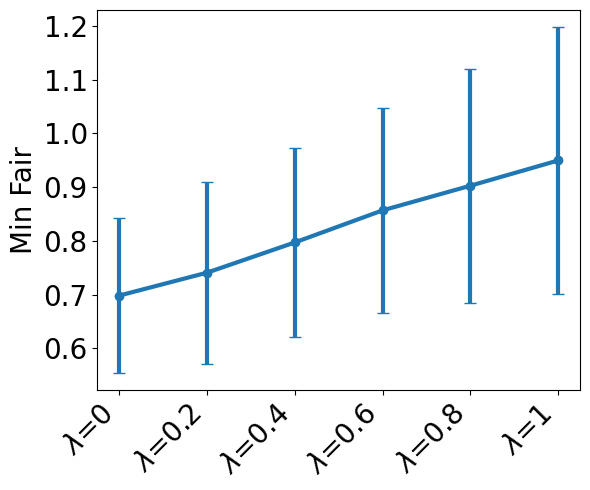

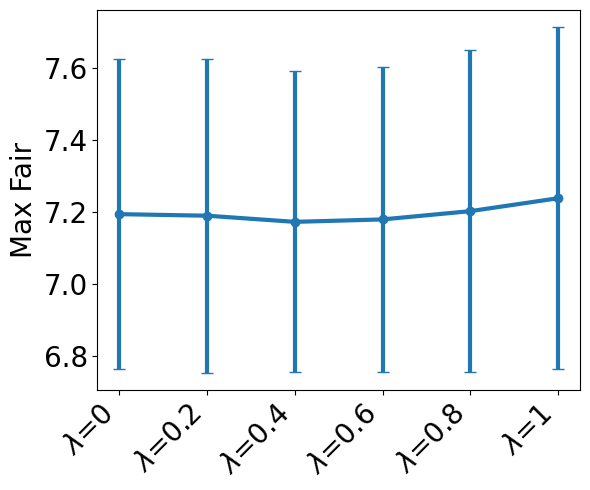

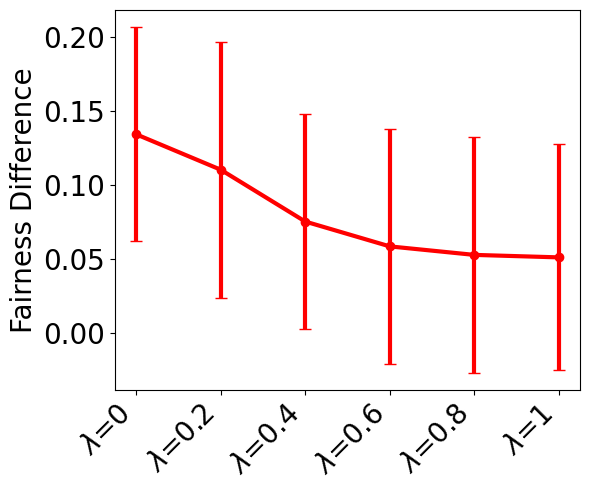

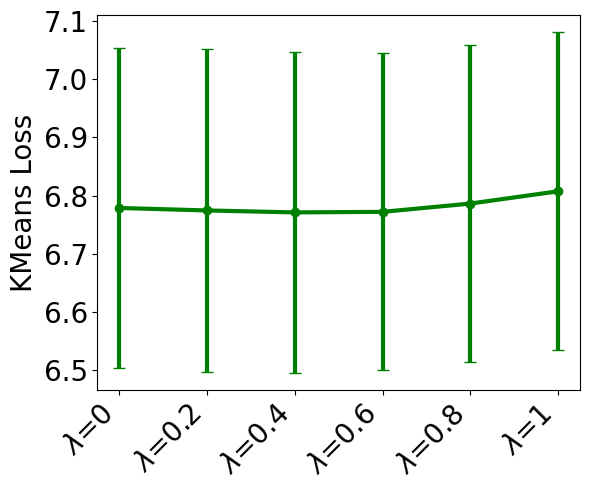

[adult] plots saved in: plots\adult


In [47]:
chosen_dataset = "adult"   # or "credit", "student", "bank"
min_fair_dict_v4, fairness_gaps_v4, kmeans_costs_v4, max_fair_dict_lambda2 = run_for_dataset(chosen_dataset)
